In [ ]:
!pip install catboost lightgbm xgboost seaborn cmaes optuna shap torch tqdm ipywidgets

In [2]:
# 필요한 라이브러리 불러오기
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load
from sklearn.metrics import roc_auc_score 
from tqdm.auto import tqdm

## 데이터 불러오기

In [3]:
# 학습 데이터
train = pd.read_csv(f'dataset/train.csv', index_col = 0)
train['original'] = False

# 테스트 데이터
test = pd.read_csv(f'dataset/test.csv', index_col = 0)
test['original'] = False

# 원본 데이터
original = pd.read_csv(f'dataset/credit_risk_dataset.csv')
original['original'] = True

# 목표 변수 설정
target = 'loan_status'

train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,original
id,,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,False
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,False
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,False
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,False
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0,False
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1,False
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1,False


## EDA
* 데이터셋 확인
* 결측치 확인
* target 확인
* 데이터 시각화

### 데이터 확인

In [15]:
# 데이터 정보 확인
train.info()
print("\n학습 데이터 갯수: ", train.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
 12  original                    58645 non-null  bool   
dtypes: bool(1), float64(3), int64(5), ob

In [16]:
# 데이터 확인
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,original
id,,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,False
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,False
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,False
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,False
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,False


In [17]:
# 데이터 통계 정보 확인
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [10]:
# 결측치 확인
train.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
original                      0
dtype: int64

In [11]:
test.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
original                      0
dtype: int64

In [18]:
# 목표 변수 확인
train[target].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

### 데이터 시각화

array([[<Axes: title={'center': 'person_age'}>,
        <Axes: title={'center': 'person_income'}>,
        <Axes: title={'center': 'person_emp_length'}>],
       [<Axes: title={'center': 'loan_amnt'}>,
        <Axes: title={'center': 'loan_int_rate'}>,
        <Axes: title={'center': 'loan_percent_income'}>],
       [<Axes: title={'center': 'cb_person_cred_hist_length'}>,
        <Axes: title={'center': 'loan_status'}>, <Axes: >]], dtype=object)

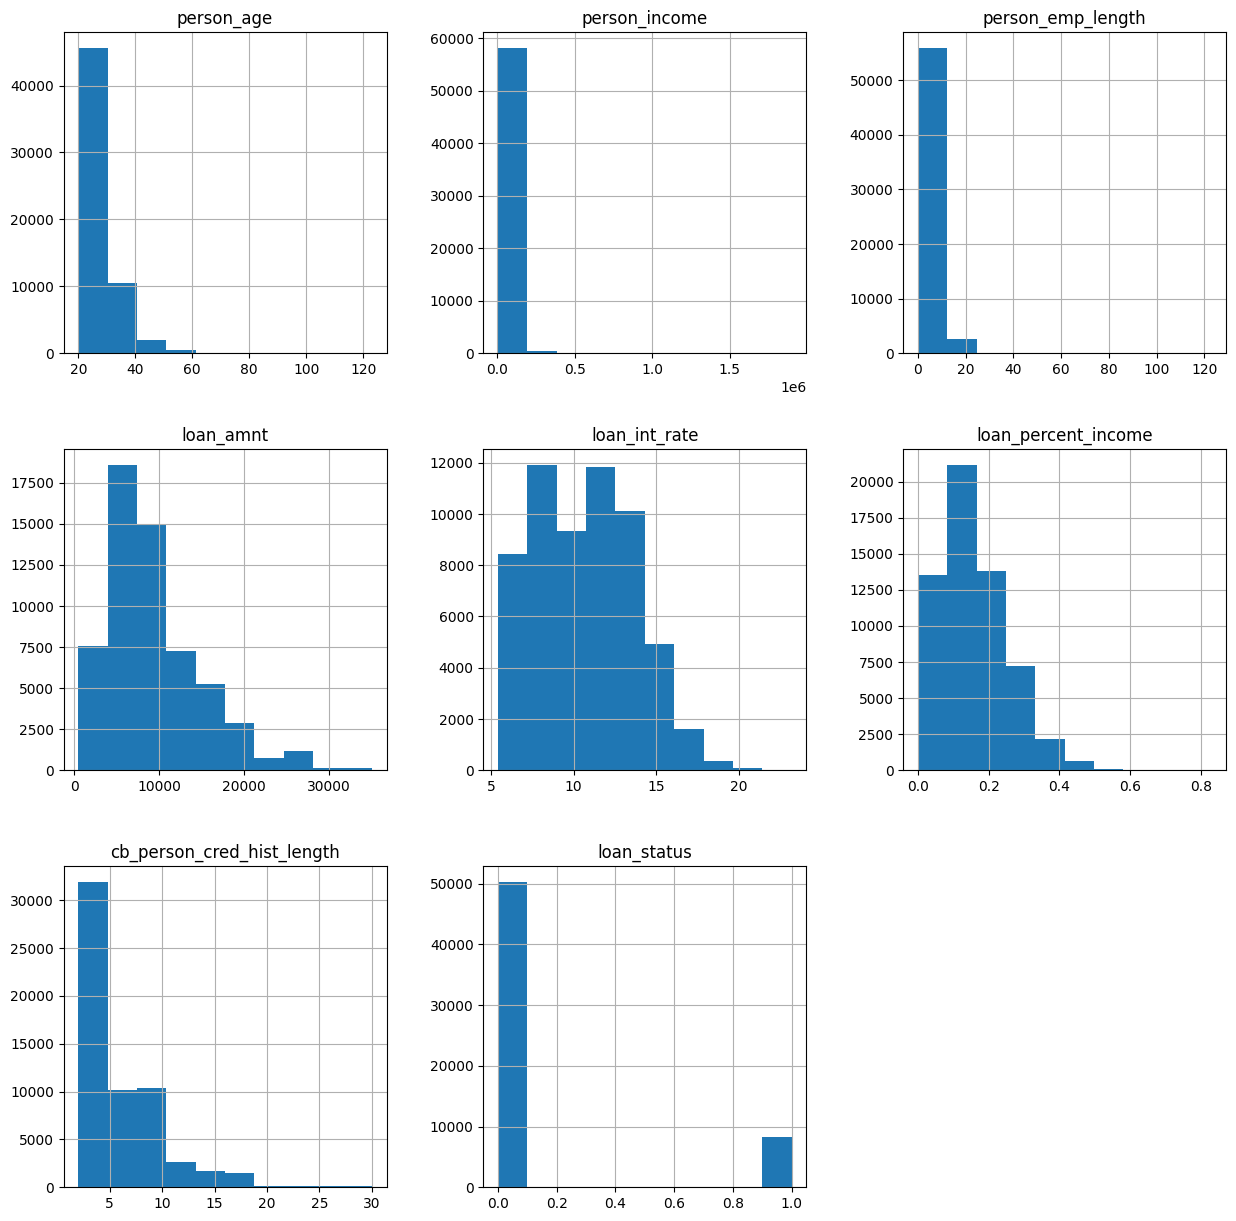

In [20]:
# 히스토그램 시각화
train.hist(figsize=(15, 15))

In [4]:
# 범주형 데이터와 타겟 변수 관계 시각화 함수
def object_data_bar_plot(df, feature, target='loan_status'):
    # 비교할 두 범주형 변수 교차표 생성
    # normalize='index' : 각 행의 합이 1이 되도록 정규화
    crosstab = pd.crosstab(df[feature], df[target], normalize='index') 
    
    # 그래프 그리기
    # stacked=True : 누적 막대 그래프 생성
    crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='coolwarm')
    
    plt.title(f'Bar Plot of {feature} vs {target}')
    plt.ylabel('Proportion')
    plt.show()

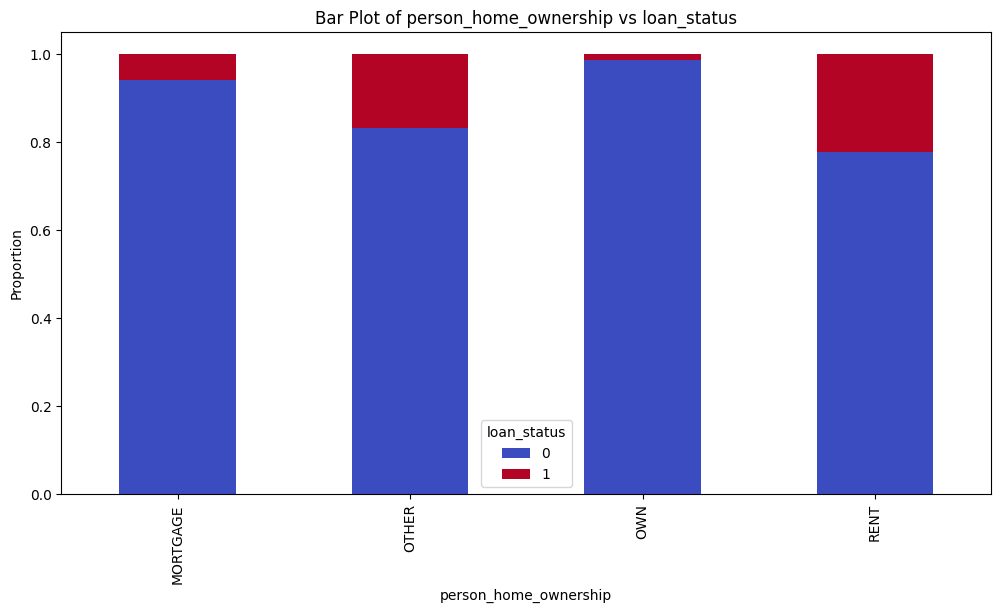

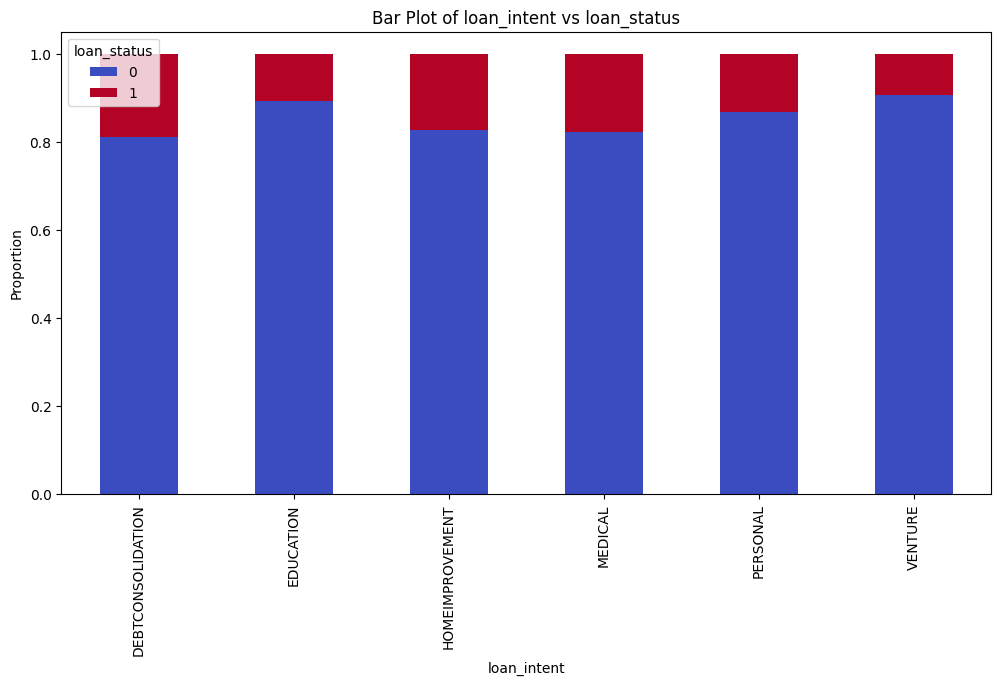

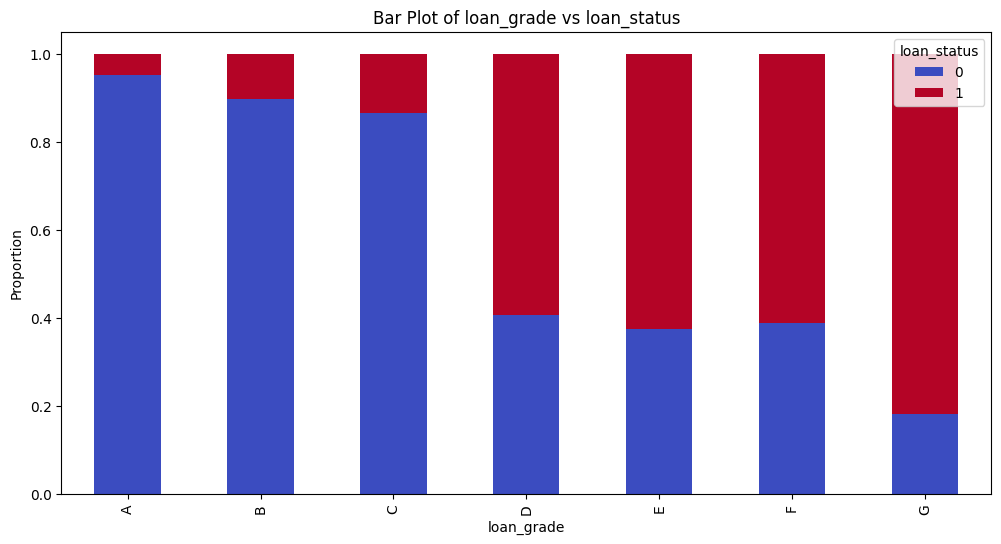

In [5]:
# object 타입 컬럼 추출
object_data = train.select_dtypes(include=['object'])

# object 타입 컬럼 관계 시각화
for i in range(len(object_data.columns)-1):
    object_data_bar_plot(train, object_data.columns[i])

countplot    
- 범주형 데이터의 빈도수를 보여주는 막대 그래프
- hue 파라미터로 여러 그룹을 비교하기 쉬움

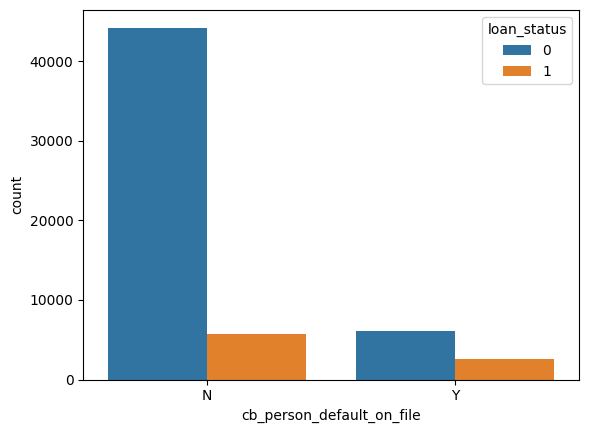

In [6]:
# 연체 기록 여부에 따른 대출 승인 여부 시각화
# plt.figure(figsize=(10, 6))
sns.countplot(data=train, x=object_data.columns[-1], hue='loan_status')
plt.show()

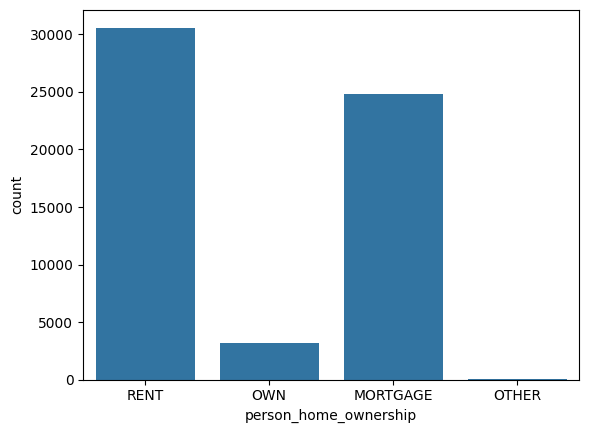

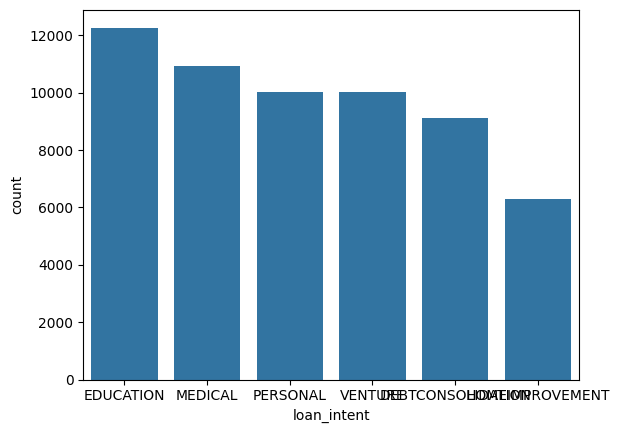

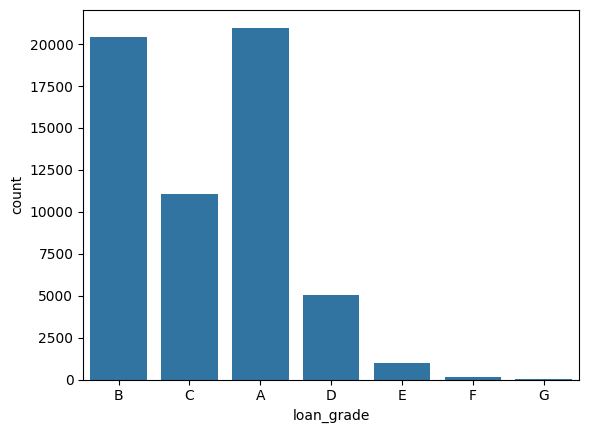

In [7]:
# 각 컬럼별 범주 시각화
for i in range(len(object_data.columns)-1):
    sns.countplot(data=train, x=object_data.columns[i])
    plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩 수행한 학습 데이터 생성을 위해 학습 데이터 복사
train_encoded = train[train.columns[:-1]].copy()

# 각 범주형 변수에 대해 라벨 인코딩 수행
for column in object_data:
    le = LabelEncoder()
    train_encoded[column] = le.fit_transform(train[column])


In [9]:
train_encoded

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,0,5.0,1,3,25000,15.95,0.21,1,10,0
58641,28,28800,3,0.0,3,2,10000,12.73,0.35,0,8,1
58642,23,44000,3,7.0,1,3,6800,16.00,0.15,0,2,1


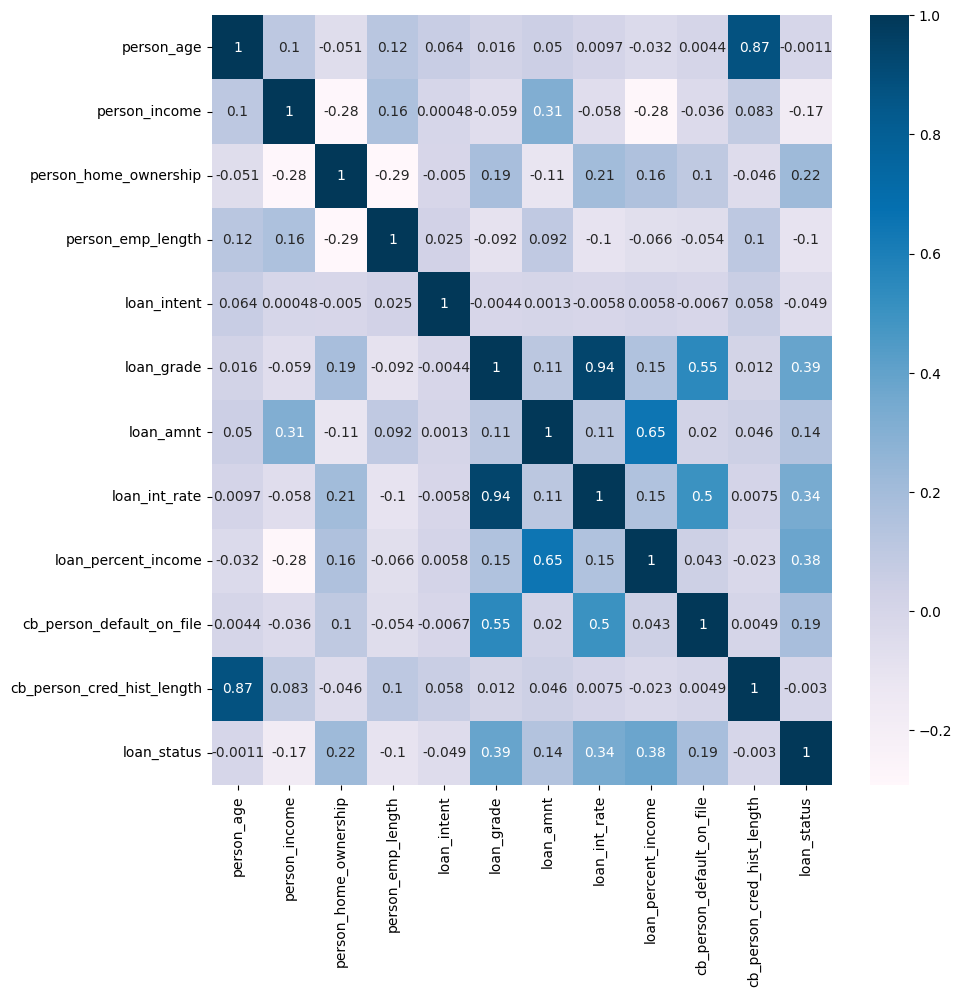

In [11]:
# 상관관계 시각화
plt.figure(figsize=(10, 10))
sns.heatmap(train_encoded[:-1].corr(), annot=True, cbar=True, cmap='PuBu')
plt.show()


필사 Notebook
----
[Boosting Synergy: Six-Model Blend for Loan Predict](https://www.kaggle.com/code/trupologhelper/boosting-synergy-six-model-blend-for-loan-predict)

## 데이터 전처리

In [62]:
# 필요한 라이브러리 불러오기
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


from sklearn.base import BaseEstimator, RegressorMixin


In [63]:
# 앙상블 모델 생성 클래스
class EnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.rf = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
        self.cb = CatBoostRegressor(n_estimators=300, random_state=0, verbose=False, thread_count=-1)
        self.lgb = LGBMRegressor(n_estimators=300, random_state=0, n_jobs=-1, verbose=-1)
        self.xgb = XGBRegressor(n_estimators=300, random_state=0, n_jobs=-1)

        # 앙상블 모델 생성
        self.models = [self.rf, self.cb, self.lgb, self.xgb]

    # 모델 학습
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        return self
    
    # 예측
    def predict(self, X):
        predictions = []
        for model in self.models:
            # 예측 결과 저장
            predictions.append(model.predict(X))
        # 예측 결과 평균 반환
        return np.mean(predictions, axis=0)

In [64]:
# target 제외한 모든 컬럼 추출
columns_to_impute = [col for col in original.columns if col not in ['loan_status', 'original']]

# 수치형, 범주형 컬럼 추출
numeric_columns = original[columns_to_impute].select_dtypes(include=['float64', 'int64']).columns
categorical_columns = original[columns_to_impute].select_dtypes(include=['object']).columns

# 컬럼 복사
df_imputed = original[columns_to_impute].copy()

# 빈 딕셔너리 생성 - 범주형 값 매핑 정보 저장
category_mappings = {}

# 범주형 컬럼 수치형으로 변환
for col in categorical_columns:
    # 범주형 컬럼의 고유값과 인덱스를 딕셔너리로 생성
    category_mappings[col] = {v:k for k,v in enumerate(df_imputed[col].unique())}
    # 범주형 컬럼의 값을 딕셔너리 인덱스로 변환
    df_imputed[col] = df_imputed[col].map(category_mappings[col])

In [65]:
category_mappings

{'person_home_ownership': {'RENT': 0, 'OWN': 1, 'MORTGAGE': 2, 'OTHER': 3},
 'loan_intent': {'PERSONAL': 0,
  'EDUCATION': 1,
  'MEDICAL': 2,
  'VENTURE': 3,
  'HOMEIMPROVEMENT': 4,
  'DEBTCONSOLIDATION': 5},
 'loan_grade': {'D': 0, 'B': 1, 'C': 2, 'A': 3, 'E': 4, 'F': 5, 'G': 6},
 'cb_person_default_on_file': {'Y': 0, 'N': 1}}

In [ ]:
# 결측치 처리 모델 생성
imputer = IterativeImputer(estimator=EnsembleRegressor(), max_iter=10, random_state=0)

# 결측치 처리
imputed_data = imputer.fit_transform(df_imputed)

# 결측치 처리 결과를 데이터프레임으로 생성
df_result = pd.DataFrame(imputed_data, columns=df_imputed.columns)

In [68]:
display(df_result)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22.0,59000.0,0.0,123.0,0.0,0.0,35000.0,16.02,0.59,0.0,3.0
1,21.0,9600.0,1.0,5.0,1.0,1.0,1000.0,11.14,0.10,1.0,2.0
2,25.0,9600.0,2.0,1.0,2.0,2.0,5500.0,12.87,0.57,1.0,3.0
3,23.0,65500.0,0.0,4.0,2.0,2.0,35000.0,15.23,0.53,1.0,2.0
4,24.0,54400.0,0.0,8.0,2.0,2.0,35000.0,14.27,0.55,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
32576,57.0,53000.0,2.0,1.0,0.0,2.0,5800.0,13.16,0.11,1.0,30.0
32577,54.0,120000.0,2.0,4.0,0.0,3.0,17625.0,7.49,0.15,1.0,19.0
32578,65.0,76000.0,0.0,3.0,4.0,1.0,35000.0,10.99,0.46,1.0,28.0
32579,56.0,150000.0,2.0,5.0,0.0,1.0,15000.0,11.48,0.10,1.0,26.0


In [69]:
# 범주형 컬럼 원래 값으로 변환
for col in categorical_columns:
    # 범주형 컬럼의 고유값과 인덱스를 딕셔너리로 생성
    reverse_mapping = {v:k for k,v in category_mappings[col].items()}
    # 범주형 컬럼의 값을 딕셔너리 인덱스로 변환
    df_result[col] = df_result[col].round().map(reverse_mapping)

# target 컬럼 추가
df_result['loan_status'] = original['loan_status']
df_result['original'] = original['original']

In [70]:
display(df_result)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,original
0,22.0,59000.0,RENT,123.0,PERSONAL,D,35000.0,16.02,0.59,Y,3.0,1,True
1,21.0,9600.0,OWN,5.0,EDUCATION,B,1000.0,11.14,0.10,N,2.0,0,True
2,25.0,9600.0,MORTGAGE,1.0,MEDICAL,C,5500.0,12.87,0.57,N,3.0,1,True
3,23.0,65500.0,RENT,4.0,MEDICAL,C,35000.0,15.23,0.53,N,2.0,1,True
4,24.0,54400.0,RENT,8.0,MEDICAL,C,35000.0,14.27,0.55,Y,4.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57.0,53000.0,MORTGAGE,1.0,PERSONAL,C,5800.0,13.16,0.11,N,30.0,0,True
32577,54.0,120000.0,MORTGAGE,4.0,PERSONAL,A,17625.0,7.49,0.15,N,19.0,0,True
32578,65.0,76000.0,RENT,3.0,HOMEIMPROVEMENT,B,35000.0,10.99,0.46,N,28.0,1,True
32579,56.0,150000.0,MORTGAGE,5.0,PERSONAL,B,15000.0,11.48,0.10,N,26.0,0,True


In [71]:
original = df_result.copy()

# 정보 확인
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  float64
 1   person_income               32581 non-null  float64
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  float64
 7   loan_int_rate               32581 non-null  float64
 8   loan_percent_income         32581 non-null  float64
 9   cb_person_default_on_file   32581 non-null  object 
 10  cb_person_cred_hist_length  32581 non-null  float64
 11  loan_status                 32581 non-null  int64  
 12  original                    32581 non-null  bool   
dtypes: bool(1), float64(7), int64(1

In [72]:
# train 데이터와 original 데이터 합치기
train = pd.concat([train, original], axis=0)
train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,original
0,37.0,35000.0,RENT,0.0,EDUCATION,B,6000.0,11.49,0.17,N,14.0,0,False
1,22.0,56000.0,OWN,6.0,MEDICAL,C,4000.0,13.35,0.07,N,2.0,0,False
2,29.0,28800.0,OWN,8.0,PERSONAL,A,6000.0,8.90,0.21,N,10.0,0,False
3,30.0,70000.0,RENT,14.0,VENTURE,B,12000.0,11.11,0.17,N,5.0,0,False
4,22.0,60000.0,RENT,2.0,MEDICAL,A,6000.0,6.92,0.10,N,3.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57.0,53000.0,MORTGAGE,1.0,PERSONAL,C,5800.0,13.16,0.11,N,30.0,0,True
32577,54.0,120000.0,MORTGAGE,4.0,PERSONAL,A,17625.0,7.49,0.15,N,19.0,0,True
32578,65.0,76000.0,RENT,3.0,HOMEIMPROVEMENT,B,35000.0,10.99,0.46,N,28.0,1,True
32579,56.0,150000.0,MORTGAGE,5.0,PERSONAL,B,15000.0,11.48,0.10,N,26.0,0,True
